In [1]:
import os
from tqdm import tqdm
import pickle5 as pickle
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
named_colors = list(mcolors.TABLEAU_COLORS)
import sys
sys.path.append('../../src')
import pysr

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
model_names = sorted(list(os.listdir('./models_pAE')))
errors = {}

In [3]:
model_names_resimulation = sorted(os.listdir('./resimulations_z'))
model_names_resimulation = [name for name in model_names_resimulation if name.startswith('pAE')]

In [4]:
with open('./test_data_max_variance.pkl', 'rb') as file:
    test_data = pickle.load(file)
    x, dx, ddx = torch.Tensor(test_data['x']), torch.Tensor(test_data['dx']), torch.Tensor(test_data['ddx'])
    z, dz = test_data['z'], test_data['dz']
    del test_data

In [5]:
res = 512
bound = 10

ddz_results = np.zeros((10, res, res))
z_encoded = []
dz_encoded = []
z_resimulations = []

In [6]:
C = np.array(np.meshgrid(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res))).T.reshape(-1, 2)

In [9]:
pysr_model_equations = []

for i, name in enumerate(tqdm(model_names)):
    model = torch.load(os.path.join('.', 'models_pAE', name)).to(device).eval()

    equation_paths = [f'./models_pAE-PySR/{name}']
    best_equations = [pysr.best_callable(pysr.get_hof(equation_file=eq_path, n_features=2)) for eq_path in equation_paths]
    pysr_model_equations.append(pysr.best(pysr.get_hof(equation_file=eq_path, n_features=2)) for eq_path in equation_paths)
    ode_equation = lambda z: np.stack([eq(z) for eq in best_equations])

    z_encoded.append(model.autoencoder.encoder(x.to(device)).detach().cpu().numpy())
    dz_encoded.append(model.transform_time_derivative_1st_order(model.autoencoder.encoder, x.to(device), dx.to(device)).detach().cpu().numpy())

    ddz_results[i] = ode_equation(C).reshape(res, res)

100%|██████████| 10/10 [00:01<00:00,  6.09it/s]


In [17]:
for pysr_model_equation in pysr_model_equations:
    for i in pysr_model_equation:
        print(i)

x0*(5.07372001786874*sin(sin(sin(sin(0.11564471*x0**2)))) - 2.4340808)
0.2063157/(x0 - 4.521325)
x0**2*sin(x0 + sin(x0) + 47.3393)/sin(sin(x1) - 418.9954)
(2.12984769842481*x0**2 - 4.10149435652126)*sin(x0 + sin(x0 + 0.44564334) + 0.6184342)
-(2.43807826302959*x0 + x1 + 8.78878318395235)/(1.7884022*x0 + 10.9297801)
0.45440114 - 2.210171*sin(2.24269*x0)/(0.31924352 - 2.032162/(x0 - sin(x0)))
-(x1**2 + 0.83062005)*sin(sin(sin(1.3519341*x0) - 0.3882888)) - 0.37398285
x0*(x0 + 2.4062452)*(sin(x0) - 0.98204136)*(sin(sin(1.24428122129288*x0)) + 0.5595024)
((1.2039673 - 0.19780107*x1)*(x0 + 7.4401975) - 4.887731)/(x0 + 7.4401975)


In [23]:
for name in model_names_resimulation:
    with open(f'./resimulations_z/{name}', 'rb') as file:
        z_resimulations.append(pickle.load(file))

In [24]:
ddz_results.shape

(10, 512, 512)

In [43]:
model_equations = [
    r'$- \frac{0.013 z \dot z^{2}}{0.009 z^{2} + \dot z \sin{(\dot z )}}$',
    r'$z (5 \sin{(\sin{(\sin{(\sin{(0.12 z^{2} )} )} )} )}$' + '\n' r'$- 2.4)$',
    r'$\frac{0.21}{z - 5}$',
    r'$\frac{z^{2} \sin{(z + \sin{(z )} + 50 )}}{\sin{(\sin{(\dot z )} - 400 )}}$',
    r'$(2.1 z^{2} - 4)$' + '\n' r'$\cdot\,\sin{(z + \sin{(z + 0.4 )} + 0.6 )}$',
    r'$- \frac{2.4 z + \dot z + 9}{1.8 z + 11}$',
    r'$0.5 - \frac{2.2 \sin{(2.2 z )}}{0.3 - \frac{2.0}{z - \sin{(z )}}}$',
    r'$- (\dot z^{2} + 0.8)$' + '\n' r'$\cdot\,\sin{(\sin{(\sin{(1.4 z )} - 0.4 )} )} - 0.4$',
    r'$z (z + 2.4) (\sin{(z )} - 1.0)$' + '\n' r'$\cdot\,(\sin{(\sin{(1.2 z )} )} + 0.6)$',
    r'$\frac{(1.2 - 0.20 \dot z) (z + 7) - 5}{z + 7}$'
]

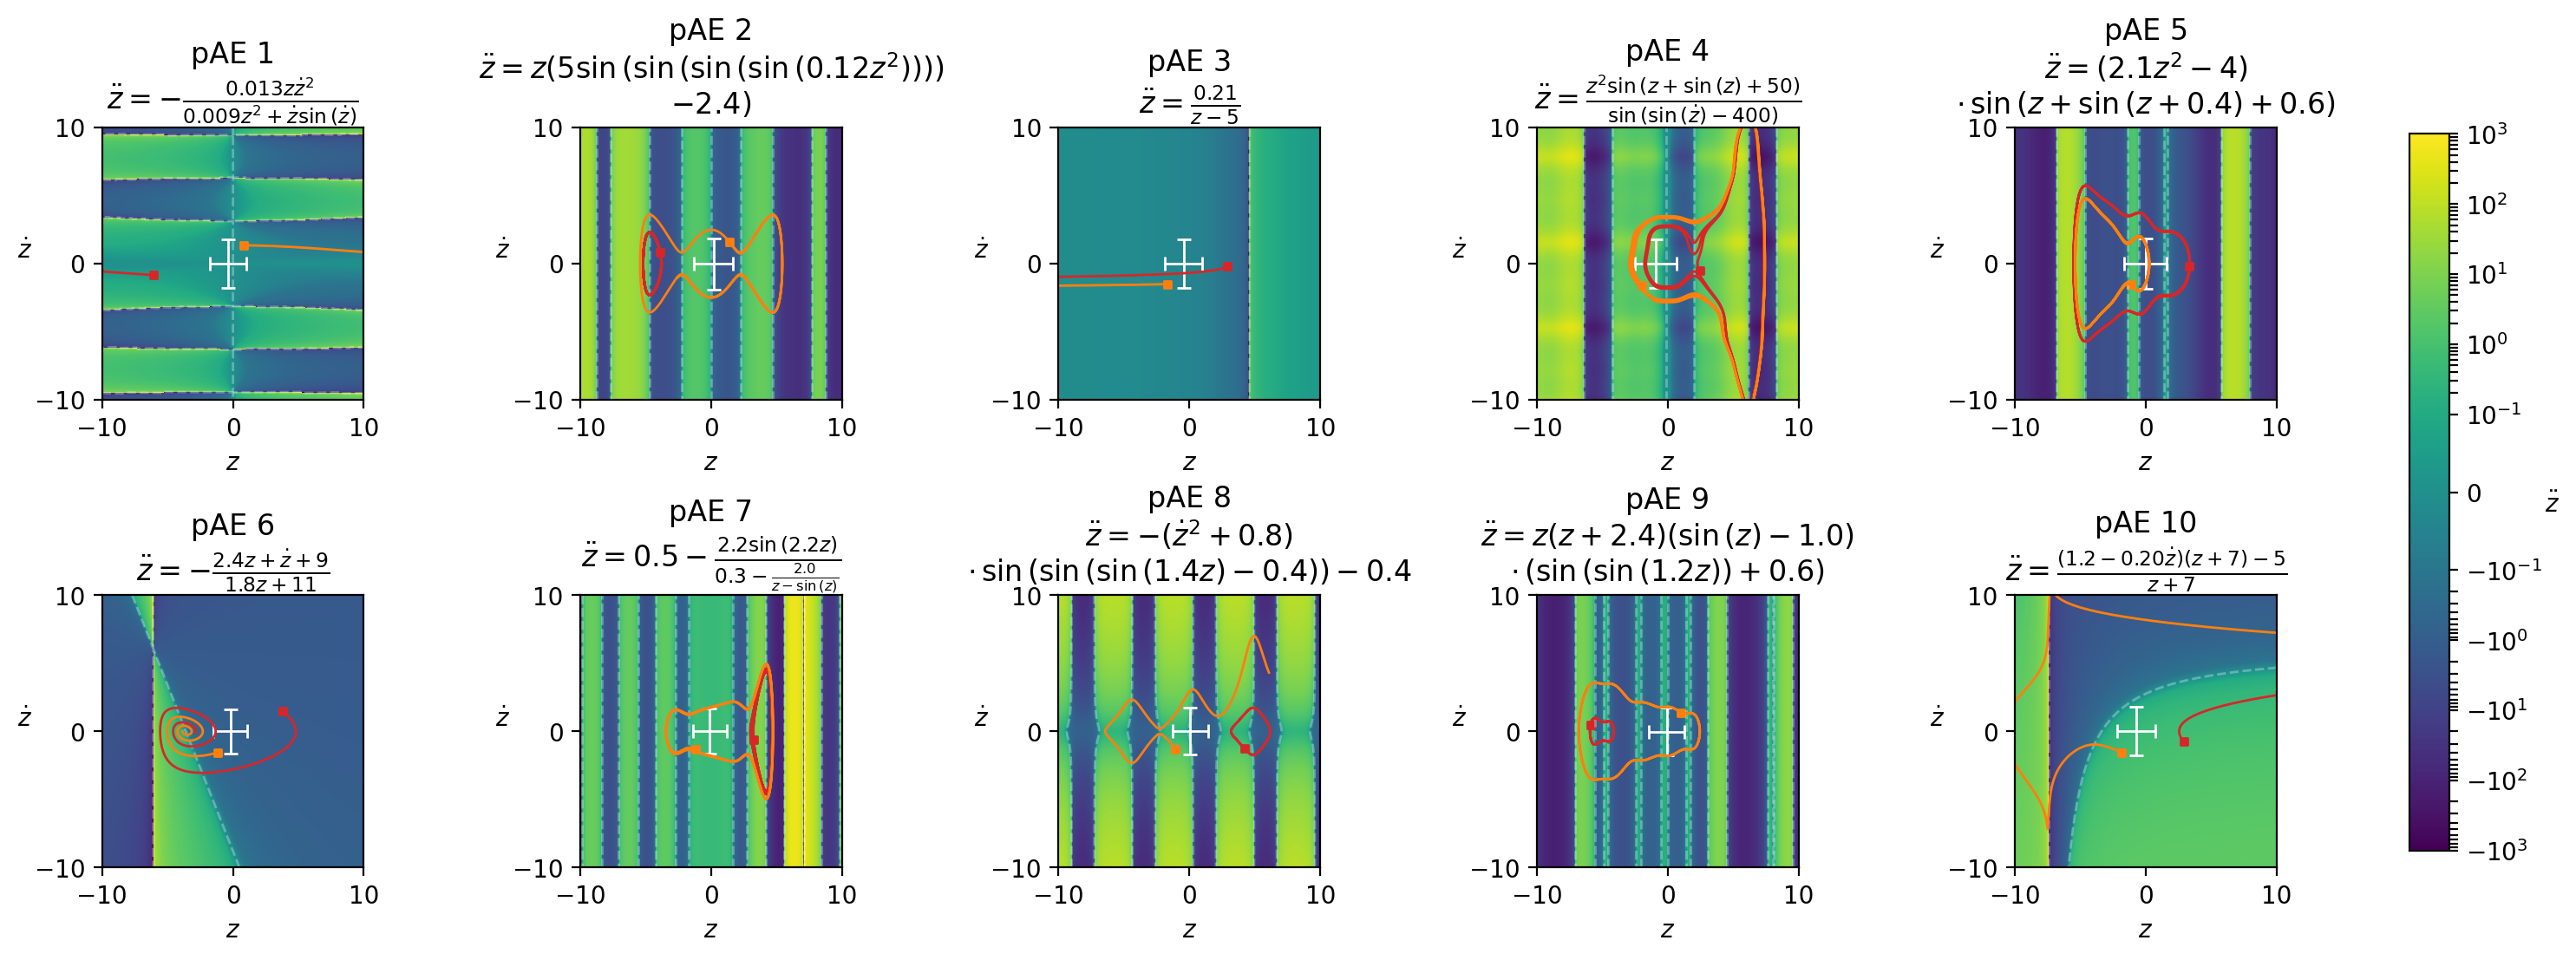

In [44]:
COLS = 5

vmin, vmax = np.min(ddz_results), np.max(ddz_results)
a = 0.9

fig, axes = plt.subplots(2, COLS, figsize=(17*a, 5.4*a), dpi=200)
fig.tight_layout(w_pad=7, h_pad=6)

for i, (eq, z_dist, dz_dist) in enumerate(zip(ddz_results, z_encoded, dz_encoded)):
    ax = axes[i//COLS][i%COLS]
    image = ax.pcolormesh(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, shading='auto', norm=mcolors.SymLogNorm(0.1, vmin=-1000, vmax=1000));
    # ax.errorbar([np.mean(z)], [np.mean(dz)], [np.std(z)], [np.std(dz)], color='red', capsize=3, linewidth=1)
    ax.errorbar([np.mean(z_dist)], [np.mean(dz_dist)], [np.std(z_dist)], [np.std(dz_dist)], color='white', capsize=3, linewidth=1)

    ax.plot(z_resimulations[i][14][:, 0], z_resimulations[i][14][:, 1], color='tab:red', linewidth=1)
    ax.scatter(z_resimulations[i][14][:1, 0], z_resimulations[i][14][:1, 1], color='tab:red', s=10, marker='s')
    ax.plot(z_resimulations[i][0][:, 0], z_resimulations[i][0][:, 1], color='tab:orange', linewidth=1)
    ax.scatter(z_resimulations[i][0][:1, 0], z_resimulations[i][0][:1, 1], color='tab:orange', s=10, marker='s')

    ax.set_ylabel(r'$\dot z$', rotation='horizontal'); ax.set_xlabel(r'$z$'); ax.set_xticks([-bound, 0, bound]); ax.set_yticks([-bound, 0, bound]); ax.set_title(f'pAE {i+1}' + '\n' + r'$\ddot z = $' + model_equations[i])
    ax.contour(np.linspace(-bound, bound, res), np.linspace(-bound, bound, res), eq.T, [0], colors='white', linewidths=1, alpha=0.3, linestyles='dashed')
    ax.set_xlim(-bound, bound); ax.set_ylim(-bound, bound)


plt.subplots_adjust(right=0.85)
cax = fig.add_axes((0.9, 0.1, 0.015, 0.85))
cbar = plt.colorbar(image, cax);
cbar.set_label(r'$\ddot z$', rotation='horizontal')